原始数据结构: <class 'dict'>
数据键: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
处理 seed 0, 结果数量: 12
  结果 0: {'m1': 2, 'm2': 20, 'rmse': tensor(4.3448, device='cuda:0'), 'mean_crps': tensor(1.6038, device='cuda:0'), 'run_time': 563.4717063903809, 'n': 20, 'batch_size': 64}
  结果 1: {'m1': 2, 'm2': 40, 'rmse': tensor(4.3662, device='cuda:0'), 'mean_crps': tensor(1.6654, device='cuda:0'), 'run_time': 545.5713665485382, 'n': 20, 'batch_size': 64}
  结果 2: {'m1': 2, 'm2': 60, 'rmse': tensor(4.4540, device='cuda:0'), 'mean_crps': tensor(1.6574, device='cuda:0'), 'run_time': 541.8151593208313, 'n': 20, 'batch_size': 64}
  结果 3: {'m1': 4, 'm2': 20, 'rmse': tensor(4.4212, device='cuda:0'), 'mean_crps': tensor(1.6293, device='cuda:0'), 'run_time': 567.1948857307434, 'n': 20, 'batch_size': 64}
  结果 4: {'m1': 4, 'm2': 40, 'rmse': tensor(4.4906, device='cuda:0'), 'mean_crps': tensor(1.5837, device='cuda:0'), 'run_time': 601.1735579967499, 'n': 20, 'batch_size': 64}
  结果 5: {'m1': 4, 'm2': 60, 'rmse': tensor(4.4455, devic

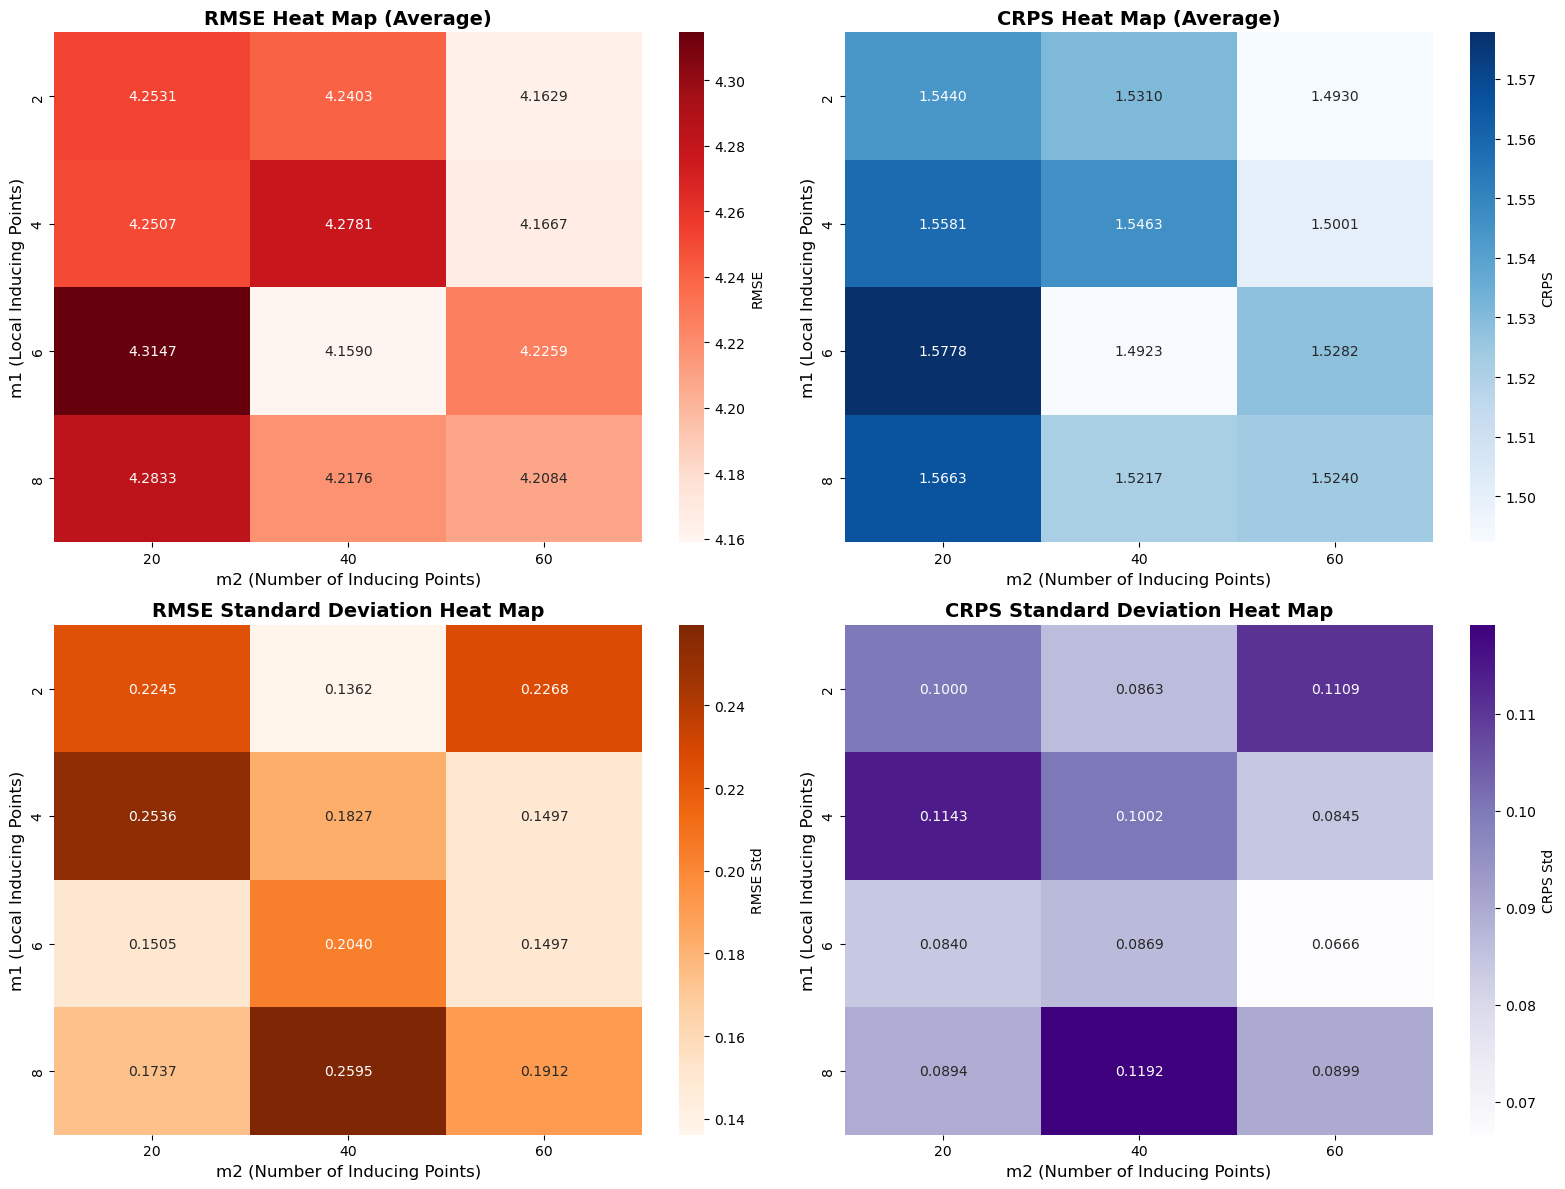


创建单独的热力图...


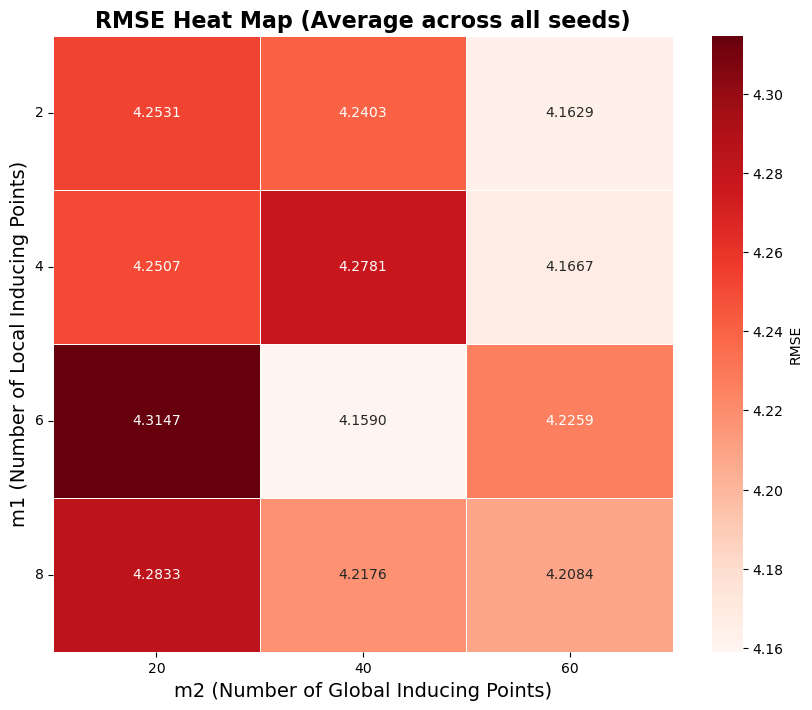

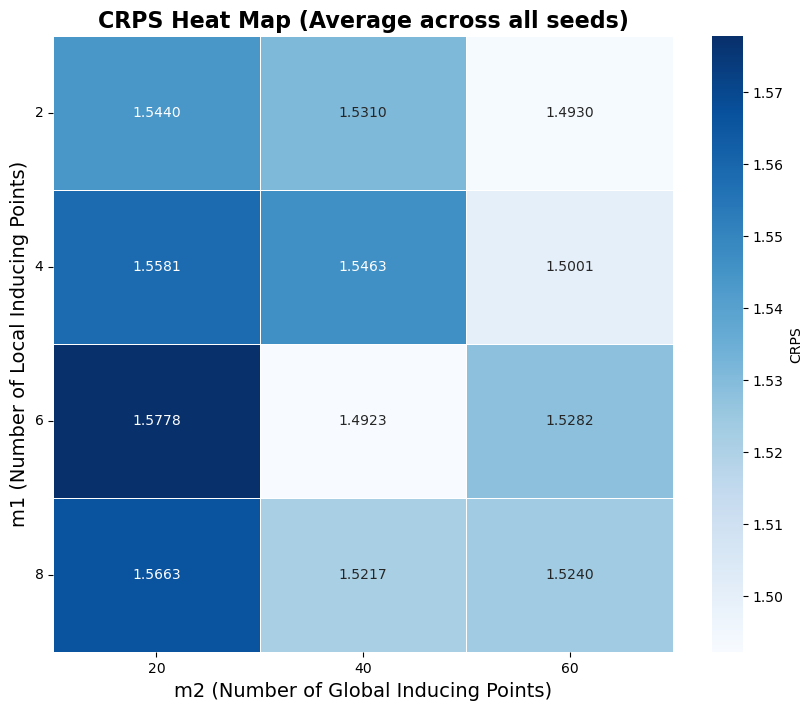


=== 最佳配置分析 ===

前 5 个最低 RMSE 配置:
分析最佳配置时出错: Column 'rmse_mean' has dtype object, cannot use method 'nsmallest' with this dtype

=== 数据摘要 ===
总实验次数: 120
不同 seed 数量: 10
不同 (m1, m2) 组合数量: 12
RMSE 范围: 3.6978 - 4.6137
CRPS 范围: 1.3095 - 1.7504
运行时间范围: 418.93 - 628.34 秒


In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

# 设置中文字体（可选）
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def load_and_process_erosion_data(filename='erosion_res.pkl'):
    """
    加载并处理 erosion_res.pkl 文件
    
    Returns:
        pandas.DataFrame: 包含所有实验结果的DataFrame
    """
    # 加载数据
    with open(filename, 'rb') as f:
        erosion_res = pickle.load(f)
    
    print("原始数据结构:", type(erosion_res))
    print("数据键:", list(erosion_res.keys()) if isinstance(erosion_res, dict) else "不是字典")
    
    # 将数据转换为DataFrame
    all_results = []
    
    for seed, results_list in erosion_res.items():
        print(f"处理 seed {seed}, 结果数量: {len(results_list)}")
        for i, result in enumerate(results_list):
            print(f"  结果 {i}: {result}")
            result_copy = result.copy()
            result_copy['seed'] = seed
            all_results.append(result_copy)
    
    df = pd.DataFrame(all_results)
    print("数据加载完成！")
    print(f"数据形状: {df.shape}")
    print(f"列名: {df.columns.tolist()}")
    
    # 检查数据类型
    print("\n数据类型:")
    print(df.dtypes)
    
    # 检查是否有缺失值
    print("\n缺失值:")
    print(df.isnull().sum())
    
    # 检查每列的样本数据
    print("\n样本数据:")
    for col in df.columns:
        print(f"{col}: {df[col].iloc[:3].tolist()}")
    
    # 转换数据类型
    numeric_columns = ['m1', 'm2', 'rmse', 'mean_crps', 'run_time', 'n', 'batch_size']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 检查转换后的数据类型
    print("\n转换后的数据类型:")
    print(df.dtypes)
    
    # 删除包含 NaN 的行
    df = df.dropna(subset=['rmse', 'mean_crps'])
    
    if df.empty:
        print("警告: 数据为空!")
        return df
    
    print(f"清理后的数据形状: {df.shape}")
    print(f"m1 的取值: {sorted(df['m1'].unique())}")
    print(f"m2 的取值: {sorted(df['m2'].unique())}")
    
    return df

def create_heatmaps(df, save_plots=True, output_dir='./'):
    """
    创建 RMSE 和 CRPS 的热力图
    
    Args:
        df: 包含实验结果的DataFrame
        save_plots: 是否保存图片
        output_dir: 保存图片的目录
    """
    if df.empty:
        print("数据为空，无法创建热力图!")
        return None, None
    
    # 计算每个 (m1, m2) 组合的平均值和标准差
    try:
        grouped = df.groupby(['m1', 'm2']).agg({
            'rmse': ['mean', 'std', 'count'],
            'mean_crps': ['mean', 'std', 'count'],
            'run_time': ['mean', 'std']
        }).round(4)
        
        # 打印统计信息
        print("\n分组统计信息:")
        print(grouped)
    except Exception as e:
        print(f"分组统计时出错: {e}")
    
    # 创建透视表用于热力图
    try:
        rmse_pivot = df.groupby(['m1', 'm2'])['rmse'].mean().unstack()
        crps_pivot = df.groupby(['m1', 'm2'])['mean_crps'].mean().unstack()
        
        # 检查透视表的数据类型
        print(f"\nrmse_pivot 数据类型: {rmse_pivot.dtypes}")
        print(f"crps_pivot 数据类型: {crps_pivot.dtypes}")
        
        # 确保数据是数值类型
        rmse_pivot = rmse_pivot.astype(float)
        crps_pivot = crps_pivot.astype(float)
        
        print(f"rmse_pivot 形状: {rmse_pivot.shape}")
        print(f"crps_pivot 形状: {crps_pivot.shape}")
        
        # 检查是否有 NaN 值
        print(f"rmse_pivot 中的 NaN 数量: {rmse_pivot.isna().sum().sum()}")
        print(f"crps_pivot 中的 NaN 数量: {crps_pivot.isna().sum().sum()}")
        
    except Exception as e:
        print(f"创建透视表时出错: {e}")
        return None, None
    
    # 创建图形
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    try:
        # 1. RMSE 热力图
        sns.heatmap(rmse_pivot, annot=True, fmt='.4f', cmap='Reds', 
                    ax=axes[0,0], cbar_kws={'label': 'RMSE'})
        axes[0,0].set_title('RMSE Heat Map (Average)', fontsize=14, fontweight='bold')
        axes[0,0].set_xlabel('m2 (Number of Inducing Points)', fontsize=12)
        axes[0,0].set_ylabel('m1 (Local Inducing Points)', fontsize=12)
        
        # 2. CRPS 热力图
        sns.heatmap(crps_pivot, annot=True, fmt='.4f', cmap='Blues', 
                    ax=axes[0,1], cbar_kws={'label': 'CRPS'})
        axes[0,1].set_title('CRPS Heat Map (Average)', fontsize=14, fontweight='bold')
        axes[0,1].set_xlabel('m2 (Number of Inducing Points)', fontsize=12)
        axes[0,1].set_ylabel('m1 (Local Inducing Points)', fontsize=12)
        
        # 3. RMSE 标准差热力图
        rmse_std_pivot = df.groupby(['m1', 'm2'])['rmse'].std().unstack().astype(float)
        sns.heatmap(rmse_std_pivot, annot=True, fmt='.4f', cmap='Oranges', 
                    ax=axes[1,0], cbar_kws={'label': 'RMSE Std'})
        axes[1,0].set_title('RMSE Standard Deviation Heat Map', fontsize=14, fontweight='bold')
        axes[1,0].set_xlabel('m2 (Number of Inducing Points)', fontsize=12)
        axes[1,0].set_ylabel('m1 (Local Inducing Points)', fontsize=12)
        
        # 4. CRPS 标准差热力图
        crps_std_pivot = df.groupby(['m1', 'm2'])['mean_crps'].std().unstack().astype(float)
        sns.heatmap(crps_std_pivot, annot=True, fmt='.4f', cmap='Purples', 
                    ax=axes[1,1], cbar_kws={'label': 'CRPS Std'})
        axes[1,1].set_title('CRPS Standard Deviation Heat Map', fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('m2 (Number of Inducing Points)', fontsize=12)
        axes[1,1].set_ylabel('m1 (Local Inducing Points)', fontsize=12)
        
        plt.tight_layout()
        
        if save_plots:
            plt.savefig(f'{output_dir}/erosion_heatmaps.png', dpi=300, bbox_inches='tight')
            plt.savefig(f'{output_dir}/erosion_heatmaps.pdf', bbox_inches='tight')
            print(f"热力图已保存到 {output_dir}/erosion_heatmaps.png")
        
        plt.show()
        
    except Exception as e:
        print(f"创建热力图时出错: {e}")
        plt.close()
        return None, None
    
    return rmse_pivot, crps_pivot

def create_individual_heatmaps(df, save_plots=True, output_dir='./'):
    """
    创建单独的大尺寸热力图
    """
    if df.empty:
        print("数据为空，无法创建热力图!")
        return
    
    try:
        # 计算透视表
        rmse_pivot = df.groupby(['m1', 'm2'])['rmse'].mean().unstack().astype(float)
        crps_pivot = df.groupby(['m1', 'm2'])['mean_crps'].mean().unstack().astype(float)
        
        # RMSE 热力图
        plt.figure(figsize=(10, 8))
        sns.heatmap(rmse_pivot, annot=True, fmt='.4f', cmap='Reds', 
                    cbar_kws={'label': 'RMSE'}, linewidths=0.5)
        plt.title('RMSE Heat Map (Average across all seeds)', fontsize=16, fontweight='bold')
        plt.xlabel('m2 (Number of Global Inducing Points)', fontsize=14)
        plt.ylabel('m1 (Number of Local Inducing Points)', fontsize=14)
        plt.xticks(rotation=0)
        plt.yticks(rotation=0)
        
        if save_plots:
            plt.savefig(f'{output_dir}/rmse_heatmap.png', dpi=300, bbox_inches='tight')
            plt.savefig(f'{output_dir}/rmse_heatmap.pdf', bbox_inches='tight')
        
        plt.show()
        
        # CRPS 热力图
        plt.figure(figsize=(10, 8))
        sns.heatmap(crps_pivot, annot=True, fmt='.4f', cmap='Blues', 
                    cbar_kws={'label': 'CRPS'}, linewidths=0.5)
        plt.title('CRPS Heat Map (Average across all seeds)', fontsize=16, fontweight='bold')
        plt.xlabel('m2 (Number of Global Inducing Points)', fontsize=14)
        plt.ylabel('m1 (Number of Local Inducing Points)', fontsize=14)
        plt.xticks(rotation=0)
        plt.yticks(rotation=0)
        
        if save_plots:
            plt.savefig(f'{output_dir}/crps_heatmap.png', dpi=300, bbox_inches='tight')
            plt.savefig(f'{output_dir}/crps_heatmap.pdf', bbox_inches='tight')
        
        plt.show()
        
    except Exception as e:
        print(f"创建单独热力图时出错: {e}")

def print_best_configurations(df, top_n=5):
    """
    打印最佳配置
    """
    if df.empty:
        print("数据为空，无法分析最佳配置!")
        return
    
    print("\n=== 最佳配置分析 ===")
    
    try:
        # 按 RMSE 排序
        rmse_stats = df.groupby(['m1', 'm2']).agg({
            'rmse': ['mean', 'std', 'count'],
            'mean_crps': ['mean', 'std'],
            'run_time': ['mean']
        }).round(4)
        
        rmse_stats.columns = ['rmse_mean', 'rmse_std', 'count', 'crps_mean', 'crps_std', 'runtime_mean']
        rmse_stats = rmse_stats.reset_index()
        
        print(f"\n前 {top_n} 个最低 RMSE 配置:")
        best_rmse = rmse_stats.nsmallest(top_n, 'rmse_mean')
        print(best_rmse)
        
        print(f"\n前 {top_n} 个最低 CRPS 配置:")
        best_crps = rmse_stats.nsmallest(top_n, 'crps_mean')
        print(best_crps)
        
        # 综合得分（RMSE 和 CRPS 归一化后求和）
        rmse_stats['rmse_norm'] = (rmse_stats['rmse_mean'] - rmse_stats['rmse_mean'].min()) / (rmse_stats['rmse_mean'].max() - rmse_stats['rmse_mean'].min())
        rmse_stats['crps_norm'] = (rmse_stats['crps_mean'] - rmse_stats['crps_mean'].min()) / (rmse_stats['crps_mean'].max() - rmse_stats['crps_mean'].min())
        rmse_stats['combined_score'] = rmse_stats['rmse_norm'] + rmse_stats['crps_norm']
        
        print(f"\n前 {top_n} 个最佳综合得分配置:")
        best_combined = rmse_stats.nsmallest(top_n, 'combined_score')
        print(best_combined[['m1', 'm2', 'rmse_mean', 'crps_mean', 'runtime_mean', 'combined_score']])
        
    except Exception as e:
        print(f"分析最佳配置时出错: {e}")

def main():
    """
    主函数
    """
    try:
        # 加载数据
        df = load_and_process_erosion_data('erosion_res.pkl')
        
        if df.empty:
            print("数据加载失败或为空!")
            return
        
        # 创建热力图
        print("\n创建热力图...")
        rmse_pivot, crps_pivot = create_heatmaps(df, save_plots=True)
        
        if rmse_pivot is not None and crps_pivot is not None:
            # 创建单独的热力图
            print("\n创建单独的热力图...")
            create_individual_heatmaps(df, save_plots=True)
        
        # 打印最佳配置
        print_best_configurations(df)
        
        # 输出数据摘要
        print("\n=== 数据摘要 ===")
        print(f"总实验次数: {len(df)}")
        print(f"不同 seed 数量: {df['seed'].nunique()}")
        print(f"不同 (m1, m2) 组合数量: {df.groupby(['m1', 'm2']).ngroups}")
        print(f"RMSE 范围: {df['rmse'].min():.4f} - {df['rmse'].max():.4f}")
        print(f"CRPS 范围: {df['mean_crps'].min():.4f} - {df['mean_crps'].max():.4f}")
        print(f"运行时间范围: {df['run_time'].min():.2f} - {df['run_time'].max():.2f} 秒")
        
    except Exception as e:
        print(f"主函数执行时出错: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [6]:
import os
import torch

def plot_metrics_boxplot(results: dict, output_file: str):
    """
    对每个方法在 RMSE 和 CRPS 上绘制 boxplot，方法动态识别，
    不再假定事先知道有哪些 base。
    """
    metrics = ['rmse', 'crps']
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes = axes.ravel()

    # 预定义常见方法的颜色，未知方法使用 'gray'
    colors = {
        'JumpGP':    'blue',
        'JumpGPsirGlobal': 'red',
        'DeepGP':    'green',
        'LMJGP':      'cyan',
        'GPsir':     'purple',
        'GP':        'orange',
        'NNJGP':     'magenta',
        'BNNJGP':    'brown',
    }
    default_color = 'gray'

    # 动态收集每个 base 方法在所有 runs 上的 (rmse, crps)
    metric_by_method = {}
    for run_res in results.values():
        for method, vals in run_res.items():
            base = method.split('_')[0]
            # 将 DJGP 替换为 LMJGP
            if base == 'DJGP':
                base = 'LMJGP'

            if base == 'DeepGP':
                base = 'DGP'

            if base == 'JGP':
                base = 'JGP-SIR'
            # 提取指标值
            raw_rmse, raw_crps = vals[0], vals[1]
            rmse = (raw_rmse.detach().cpu().item()
                    if isinstance(raw_rmse, torch.Tensor)
                    else float(raw_rmse))
            crps = (raw_crps.detach().cpu().item()
                    if isinstance(raw_crps, torch.Tensor)
                    else float(raw_crps))
            metric_by_method.setdefault(base, []).append((rmse, crps))

    # 准备排序后的标签列表，保证图中方法顺序一致
    labels = sorted(metric_by_method.keys())

    # 对每个指标画 boxplot
    for i, metric in enumerate(metrics):
        ax = axes[i]
        data = [
            [entry[i] for entry in metric_by_method[base]]
            for base in labels
        ]

        # 绘制 boxplot
        bp = ax.boxplot(
            data,
            tick_labels=labels,
            patch_artist=True,
            showfliers=False
        )
        # 根据方法名上色
        for patch, base in zip(bp['boxes'], labels):
            color = colors.get(base, default_color)
            # patch.set_facecolor(color)
            patch.set_facecolor('gray')
            patch.set_edgecolor('black')

        ax.set_title(f'{metric.upper()} by Method')
        ax.set_ylabel(metric.upper())
        ax.grid(True, axis='y')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"Saved boxplot to {output_file}")

foldername = 'exp_data/expansion methods'
beforename = 'results_D=20_Q=4_M=25_K=3_N=1000_noise_var=4_method='
for method in ["random projection", "rff", "autoencoder", "polynomial"]:
    pklname = os.path.join(foldername, f'{beforename}{method}.pkl')
    with open(pklname, 'rb') as f:
        results = pickle.load(f)

    plot_metrics_boxplot(results, os.path.join(foldername, f'{beforename}{method}_boxplot.png'))


Saved boxplot to exp_data/expansion methods\results_D=20_Q=4_M=25_K=3_N=1000_noise_var=4_method=random projection_boxplot.png
Saved boxplot to exp_data/expansion methods\results_D=20_Q=4_M=25_K=3_N=1000_noise_var=4_method=rff_boxplot.png
Saved boxplot to exp_data/expansion methods\results_D=20_Q=4_M=25_K=3_N=1000_noise_var=4_method=autoencoder_boxplot.png
Saved boxplot to exp_data/expansion methods\results_D=20_Q=4_M=25_K=3_N=1000_noise_var=4_method=polynomial_boxplot.png


In [9]:
pklname = 'exp_data/jgp_alone/expansion methods_4Q_1000N_20D/results_D=20_Q=4_M=25_K=3_N=1000_noise_var=4_method=polynomial.pkl'
with open(pklname, 'rb') as f:
    results_jgp = pickle.load(f)

In [10]:
results_jgp

{'1': {'JGP_SIR': [tensor(290.1468), tensor(131.2297), 8.308900117874146],
  'JGP_RAW': [tensor(337.1208), tensor(159.2665), 43.294161319732666],
  'DGP_0': [317.0786437988281, 297.848876953125, 27.765212774276733],
  'LMJGP_0': [tensor(279.4799, device='cuda:0'),
   tensor(124.2638, device='cuda:0'),
   109.14283680915833]},
 '2': {'JGP_SIR': [tensor(267.8951), tensor(120.3152), 7.8609299659729],
  'JGP_RAW': [tensor(270.9934), tensor(111.9709), 47.617098569869995],
  'DGP_0': [301.346923828125, 272.17852783203125, 27.24110198020935],
  'LMJGP_0': [tensor(289.4254, device='cuda:0'),
   tensor(134.0875, device='cuda:0'),
   109.38439393043518]},
 '3': {'JGP_SIR': [tensor(281.2639), tensor(116.9509), 8.605777025222778],
  'JGP_RAW': [tensor(421.5443), tensor(230.2152), 40.876851320266724],
  'DGP_0': [338.8435363769531, 322.46124267578125, 27.70531153678894],
  'LMJGP_0': [tensor(327.5737, device='cuda:0'),
   tensor(155.4448, device='cuda:0'),
   111.1729371547699]},
 '4': {'JGP_SIR': 

In [16]:
def plot_metrics_boxplot(results: dict, output_file: str):
    """
    Plot boxplots for RMSE and CRPS across methods, with mean lines overlaid.
    """
    metrics = ['rmse', 'crps']
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes = axes.ravel()

    colors = {
        'JGP_RAW':    'blue',
        'JGP_SIR': 'red',
        'DGP':    'green',
        'LMJGP':      'cyan',
        'GPsir':     'purple',
        'GP':        'orange',
        'NNJGP':     'magenta',
        'BNNJGP':    'brown',
    }
    default_color = 'gray'

    metric_by_method = {}
    for run_res in results.values():
        for method, vals in run_res.items():
            if method == 'JGP_SIR':
                method = 'JGP-SIR'
            if method == 'JGP_RAW':
                method = 'JGP-RAW'
            base = method.split('_')[0]
            if base == 'DJGP':
                base = 'LMJGP'

            raw_rmse, raw_crps = vals[0], vals[1]
            rmse = (raw_rmse.detach().cpu().item()
                    if isinstance(raw_rmse, torch.Tensor)
                    else float(raw_rmse))
            crps = (raw_crps.detach().cpu().item()
                    if isinstance(raw_crps, torch.Tensor)
                    else float(raw_crps))
            metric_by_method.setdefault(base, []).append((rmse, crps))

    labels = sorted(metric_by_method.keys())

    for i, metric in enumerate(metrics):
        ax = axes[i]
        data = [
            [entry[i] for entry in metric_by_method[base]]
            for base in labels
        ]

        # Draw boxplots
        bp = ax.boxplot(
            data,
            tick_labels=labels,
            patch_artist=True,
            showfliers=False
        )

        # Color patches
        for patch, base in zip(bp['boxes'], labels):
            patch.set_facecolor('gray')
            patch.set_edgecolor('black')

        # Overlay mean line
        means = [sum(values) / len(values) for values in data]
        ax.plot(range(1, len(labels) + 1), means, marker='o', color='black', linestyle='--', label='Mean')

        ax.set_title(f'{metric.upper()} by Method')
        ax.set_ylabel(metric.upper())
        ax.grid(True, axis='y')
        ax.tick_params(axis='x', rotation=45)
        ax.legend()

    plt.tight_layout()
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"Saved boxplot to {output_file}")


In [17]:
for method in ["random projection", "rff", "autoencoder", "polynomial"]:
    pklname = f'exp_data/jgp_alone/expansion methods_4Q_1000N_20D/results_D=20_Q=4_M=25_K=3_N=1000_noise_var=4_method={method}.pkl'
    with open(pklname, 'rb') as f:
        results_jgp = pickle.load(f)
    plot_metrics_boxplot(results_jgp, f'exp_data/jgp_alone/expansion methods_4Q_1000N_20D/results_D=20_Q=4_M=25_K=3_N=1000_noise_var=4_method={method}.png')

Saved boxplot to exp_data/jgp_alone/expansion methods_4Q_1000N_20D/results_D=20_Q=4_M=25_K=3_N=1000_noise_var=4_method=random projection.png
Saved boxplot to exp_data/jgp_alone/expansion methods_4Q_1000N_20D/results_D=20_Q=4_M=25_K=3_N=1000_noise_var=4_method=rff.png
Saved boxplot to exp_data/jgp_alone/expansion methods_4Q_1000N_20D/results_D=20_Q=4_M=25_K=3_N=1000_noise_var=4_method=autoencoder.png
Saved boxplot to exp_data/jgp_alone/expansion methods_4Q_1000N_20D/results_D=20_Q=4_M=25_K=3_N=1000_noise_var=4_method=polynomial.png
